## Create a Dataset
We start by creating a simple dataset with two features. We use the numpy library to create the dataset and the matplotlib library to plot it.
<br><br>

本實驗將展示兩種常見的降維回歸技術：  
- PCR（Principal Component Regression）  
- PLS（Partial Least Squares Regression）
<br>
我們會在一組簡單的二維資料上比較它們的預測效果，並用圖表與 R² 分數來驗證哪一種方法在本案例中表現更好。

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

## 🧪 Step 1：建立資料集（Create a Dataset）

- 我們用 `numpy` 建立一個 2D 資料集，總共 500 筆資料。
- 資料有一點「橢圓形」的分佈（使用協方差矩陣產生）
- 使用 `matplotlib` 畫出這些點的散佈圖。

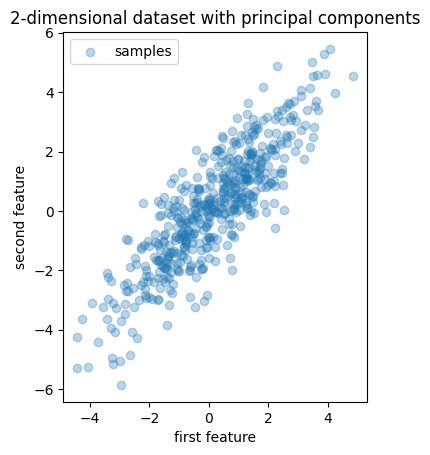

In [33]:
rng = np.random.RandomState(0)
n_samples = 500
cov = [[3, 3], [3, 4]]
X = rng.multivariate_normal(mean=[0, 0], cov=cov, size=n_samples)
plt.scatter(X[:, 0], X[:, 1], alpha=0.3, label="samples")
plt.gca().set(
    aspect="equal",
    title="2-dimensional dataset with principal components",
    xlabel="first feature",
    ylabel="second feature",
)
plt.legend()
plt.show()

## Define the Target
For the purpose of this example, we define the target y such that it is strongly correlated with a direction that has a small variance. We project X onto the second component and add some noise to it.
<br>
## 🎯 Step 2：定義目標值 y（Define the Target）

- 我們假設真實的 y 是根據資料中「變異較小」的方向來決定的。
- 為此，我們將資料投影到第二主成分（變異最小方向），並加上一些隨機雜訊來當作 y 值。

👉 這樣的設計是為了讓 **PLS 比 PCR 有優勢**，因為 PCR 只考慮變異最大方向，而不管 y 有沒有關聯。


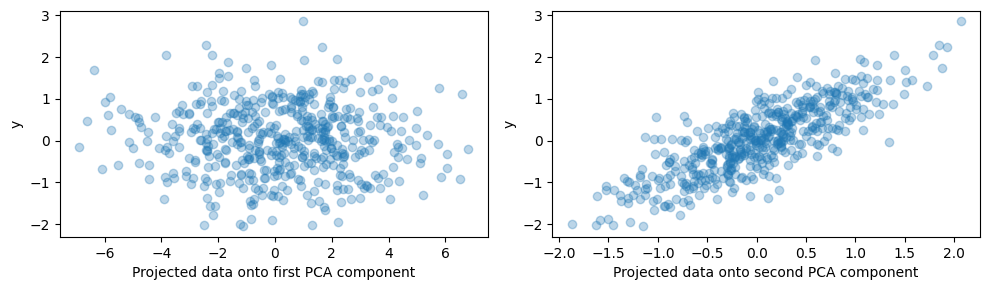

In [21]:
pca = PCA(n_components=2)
pca.fit(X)

y = X.dot(pca.components_[1]) + rng.normal(size=n_samples) / 2

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].scatter(X.dot(pca.components_[0]), y, alpha=0.3)
axes[0].set(xlabel="Projected data onto first PCA component", ylabel="y")
axes[1].scatter(X.dot(pca.components_[1]), y, alpha=0.3)
axes[1].set(xlabel="Projected data onto second PCA component", ylabel="y")
plt.tight_layout()
plt.show()

## Create the Regressors
We create two regressors: PCR and PLS, and for our illustration purposes, we set the number of components to 
1. Before feeding the data to the PCA step of PCR, we first standardize it, as recommended by good practice.
2. The PLS estimator has built-in scaling capabilities.
<br>
## 🏗️ Step 3：建立回歸模型（Create the Regressors）

我們建立兩種模型：

| 模型     | 說明                                           |
|----------|------------------------------------------------|
| PCR      | 先用 PCA 降維（選一個主成分）→ 再做線性回歸     |
| PLS      | 同時考慮特徵與 y 的關聯性來選擇主成分，並回歸   |

- PCR 需要先做標準化（StandardScaler）
- PLS 內建標準化功能


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)

PLSRegression(n_components=1)

## Compare the Regressors
We plot the projected data onto the first component against the target for both the PCR and PLS regressors. In both cases, this projected data is what the regressors will use as training data.
<br>
## 📈 Step 4：投影與視覺化（Compare the Regressors）

畫兩張圖來比較：

1. PCR 模型：
   - 顯示原始 y（真實值）與預測值在第一主成分上的對比
2. PLS 模型：
   - 顯示 PLS 的結果與預測值的對比

這兩張圖都幫助我們直觀地看出哪一種模型預測得更貼近真實。


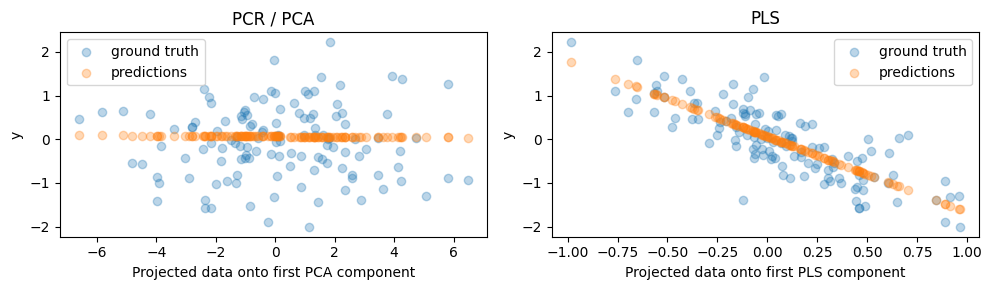

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[0].scatter(
    pca.transform(X_test), pcr.predict(X_test), alpha=0.3, label="predictions"
)
axes[0].set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="PCR / PCA"
)
axes[0].legend()
axes[1].scatter(pls.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[1].scatter(
    pls.transform(X_test), pls.predict(X_test), alpha=0.3, label="predictions"
)
axes[1].set(xlabel="Projected data onto first PLS component", ylabel="y", title="PLS")
axes[1].legend()
plt.tight_layout()
plt.show()

In [25]:
print(f"PCR r-squared {pcr.score(X_test, y_test):.3f}")
print(f"PLS r-squared {pls.score(X_test, y_test):.3f}")

PCR r-squared -0.026
PLS r-squared 0.658


## Use PCR with 2 Components
We use PCR with 2 components to compare it with PLS.

In [26]:
pca_2 = make_pipeline(PCA(n_components=2), LinearRegression())
pca_2.fit(X_train, y_train)
print(f"PCR r-squared with 2 components {pca_2.score(X_test, y_test):.3f}")

PCR r-squared with 2 components 0.673


## Summary
In this lab, we compared PCR and PLS on a toy dataset. We found that PLS performed better than PCR when the target is strongly correlated with directions that have low variance.

1. PCR 是用 PCA 降維後再回歸，PLS 是一起考慮 y 的資訊來降維
2. 當 y 和低變異方向有關時，PCR 可能會忽略它
3. PLS 在這種情況下能選對方向，預測效果會更好
4. sklearn 提供了簡潔的方式整合標準化、降維與回歸

1. 化學光譜分析PLS
2. 高維基因表達數據PCR/PLS
3. 資料中有多重共線性PLS
4. 資料集中 x 和 y 關聯不明確，PCR 可能會失準，PLS 較穩定